# Conditional Neural Processes (CNP).
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter

import yaml

In [2]:
with open("binary-black-hole/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

TRAINING_EPOCHS = int(config_file["cnp_settings"]["training_epochs"]) # Total number of training points: training_iterations * batch_size * max_content_points
PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
BATCH_SIZE = config_file["cnp_settings"]["batch_size"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

version_cnp= config_file["cnp_settings"]["version"]
version_lf= config_file["simulation_settings"]["version_lf"]

path_out = config_file["path_settings"]["path_out"]
f_out = config_file["path_settings"]["f_out"]



In [3]:
x_size, y_size = utils.get_feature_and_label_size(config_file)

Data Augmentation in Progress: Applying transformations...


100%|██████████| 212/212 [00:01<00:00, 110.55it/s]


2025-04-04 14:01:09 Iteration: 0/0, train loss: 0.7697 (vs BCE 0.6961)
2025-04-04 14:01:09, Iteration: 0, test loss: 0.8304 (vs BCE 0.7166)


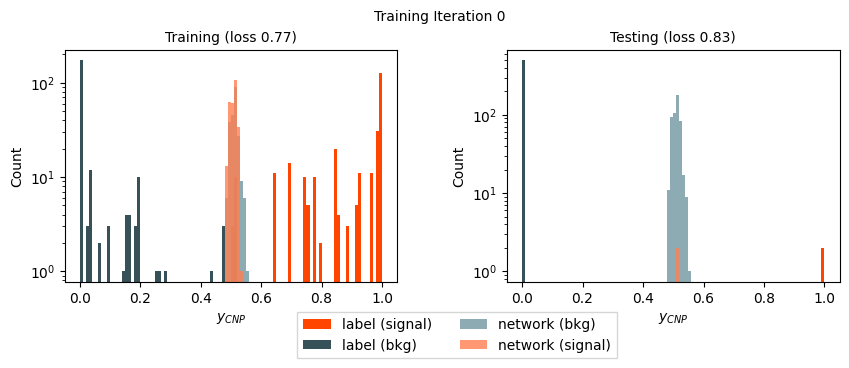

2025-04-04 14:01:14 Iteration: 0/50, train loss: 0.7679 (vs BCE 0.6760)
2025-04-04 14:01:14, Iteration: 50, test loss: 0.8482 (vs BCE 0.7565)


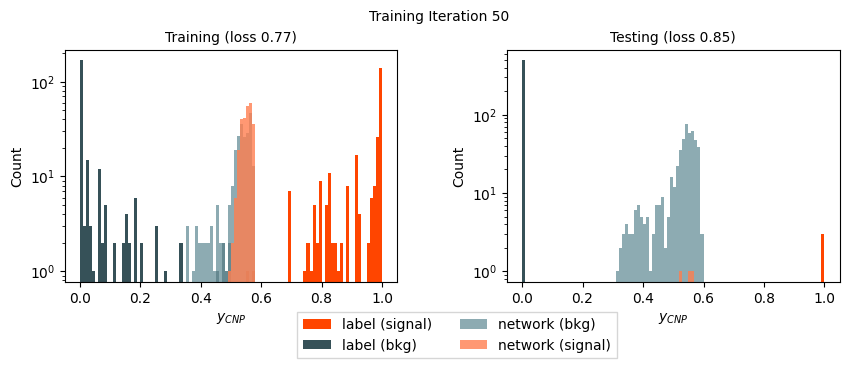

2025-04-04 14:01:21 Iteration: 0/100, train loss: 0.7302 (vs BCE 0.5972)
2025-04-04 14:01:21, Iteration: 100, test loss: 0.7659 (vs BCE 0.5765)


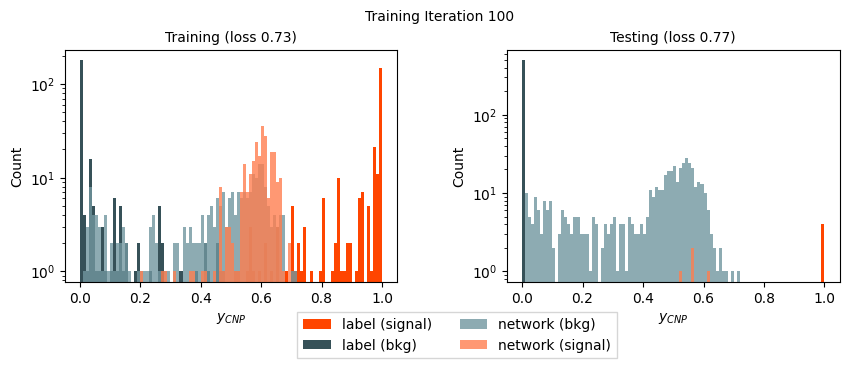

2025-04-04 14:01:26 Iteration: 0/150, train loss: 0.7149 (vs BCE 0.5563)
2025-04-04 14:01:26, Iteration: 150, test loss: 0.6988 (vs BCE 0.4261)


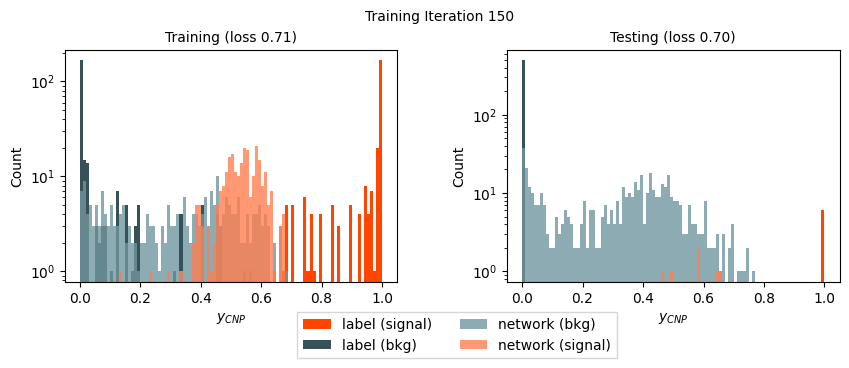

2025-04-04 14:01:31 Iteration: 0/200, train loss: 0.7047 (vs BCE 0.5603)
2025-04-04 14:01:31, Iteration: 200, test loss: 0.7584 (vs BCE 0.5521)


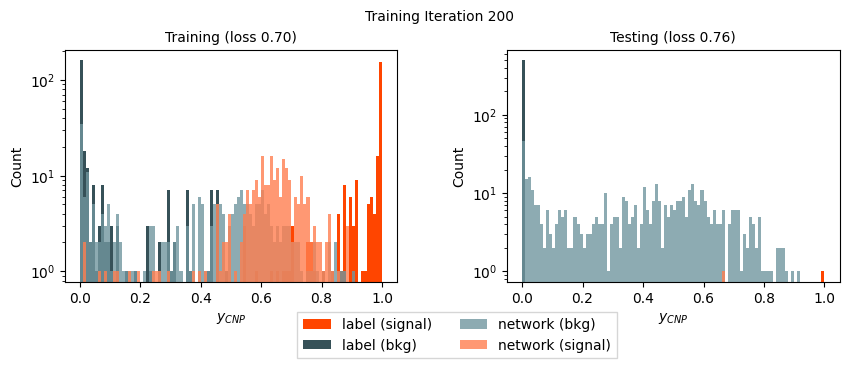

2025-04-04 14:01:36 Iteration: 0/250, train loss: 0.7021 (vs BCE 0.5806)
2025-04-04 14:01:36, Iteration: 250, test loss: 0.7122 (vs BCE 0.4462)


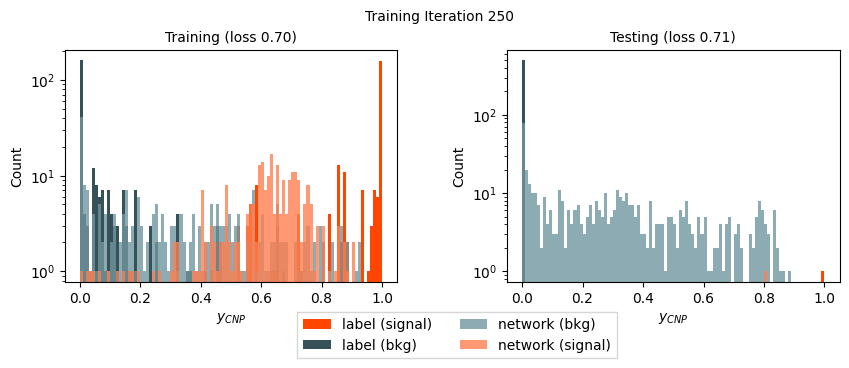

2025-04-04 14:01:40 Iteration: 0/300, train loss: 0.6964 (vs BCE 0.5791)
2025-04-04 14:01:40, Iteration: 300, test loss: 0.7832 (vs BCE 0.6256)


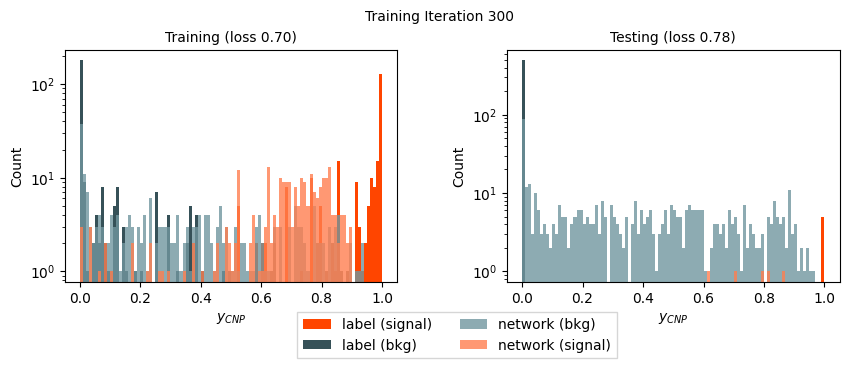

2025-04-04 14:01:45 Iteration: 0/350, train loss: 0.6745 (vs BCE 0.4917)
2025-04-04 14:01:45, Iteration: 350, test loss: 0.7508 (vs BCE 0.5378)


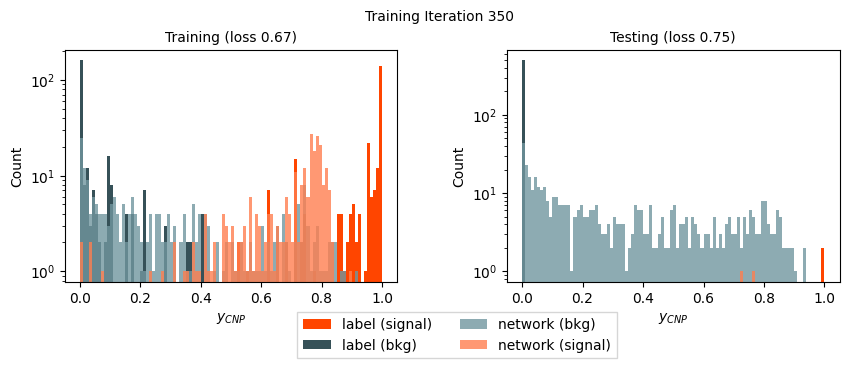

2025-04-04 14:01:50 Iteration: 0/400, train loss: 0.6824 (vs BCE 0.5368)
2025-04-04 14:01:50, Iteration: 400, test loss: 0.7008 (vs BCE 0.4273)


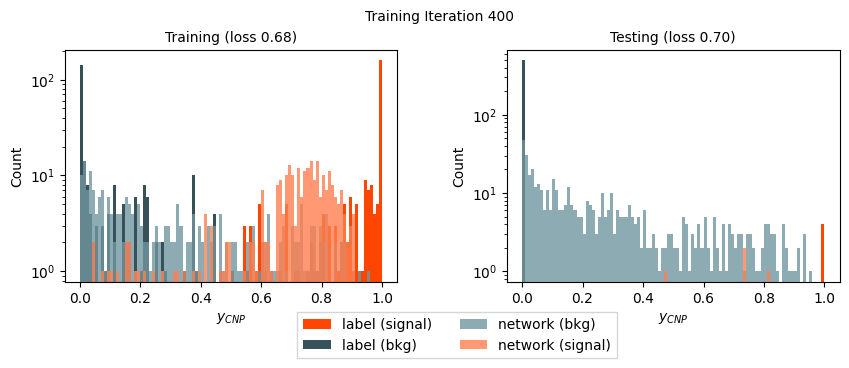

Finished full dataset pass. Starting new epoch! 
Data Augmentation in Progress: Applying transformations...


100%|██████████| 212/212 [00:01<00:00, 129.75it/s]


2025-04-04 14:02:11 Iteration: 1/450, train loss: 0.6620 (vs BCE 0.4727)
2025-04-04 14:02:11, Iteration: 450, test loss: 0.7367 (vs BCE 0.5165)


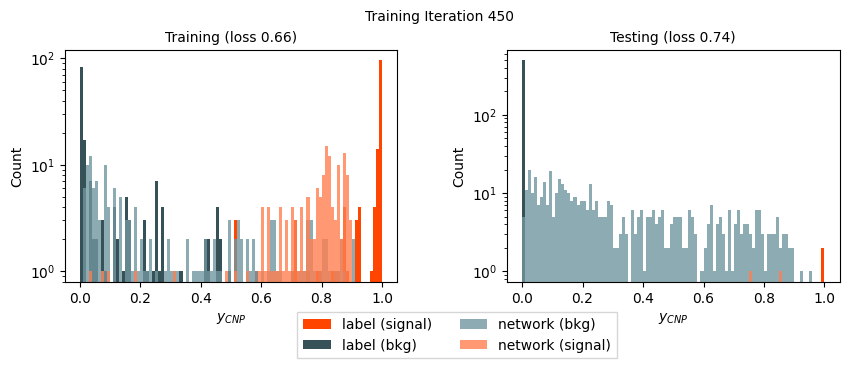

2025-04-04 14:02:17 Iteration: 1/500, train loss: 0.6652 (vs BCE 0.4687)
2025-04-04 14:02:17, Iteration: 500, test loss: 0.7117 (vs BCE 0.4588)


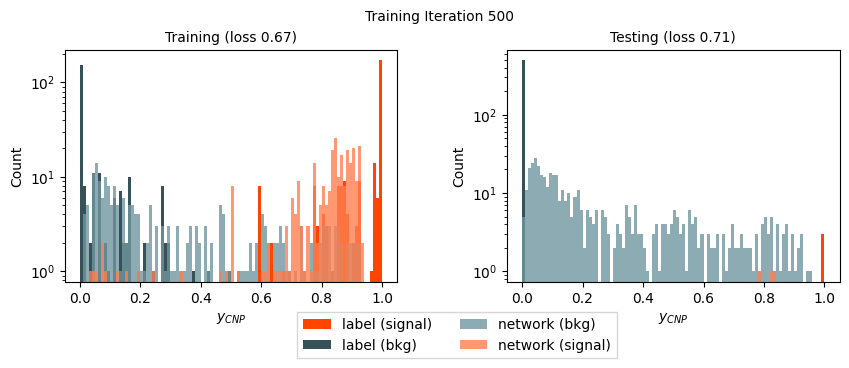

2025-04-04 14:02:22 Iteration: 1/550, train loss: 0.6588 (vs BCE 0.5053)
2025-04-04 14:02:22, Iteration: 550, test loss: 0.6710 (vs BCE 0.3531)


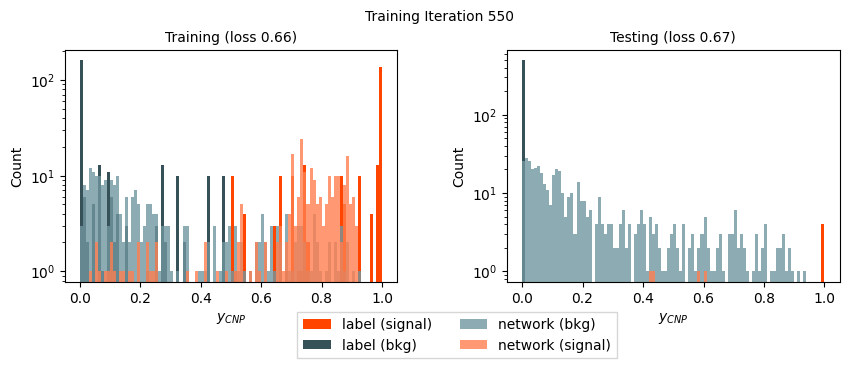

2025-04-04 14:02:27 Iteration: 1/600, train loss: 0.6412 (vs BCE 0.4164)
2025-04-04 14:02:27, Iteration: 600, test loss: 0.6302 (vs BCE 0.2512)


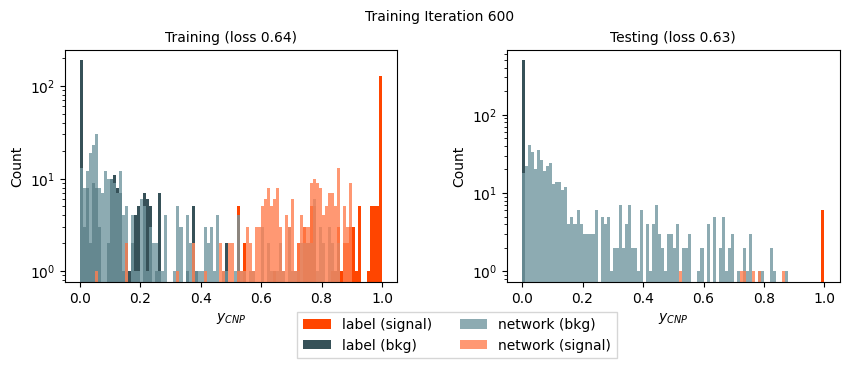

2025-04-04 14:02:32 Iteration: 1/650, train loss: 0.6539 (vs BCE 0.4424)
2025-04-04 14:02:32, Iteration: 650, test loss: 0.6778 (vs BCE 0.3831)


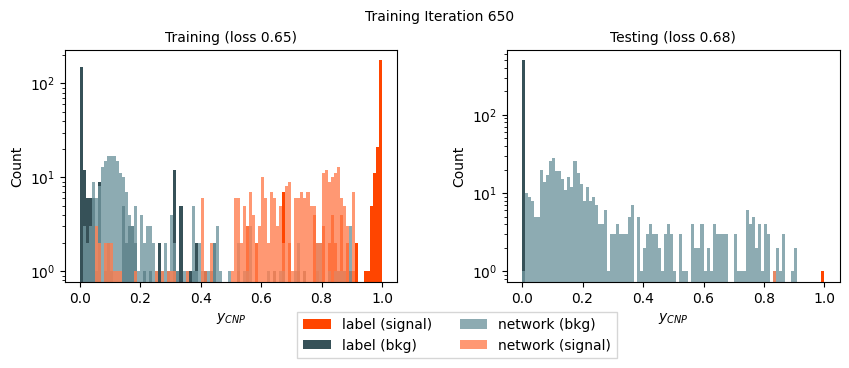

2025-04-04 14:02:37 Iteration: 1/700, train loss: 0.6489 (vs BCE 0.4323)
2025-04-04 14:02:37, Iteration: 700, test loss: 0.6396 (vs BCE 0.2861)


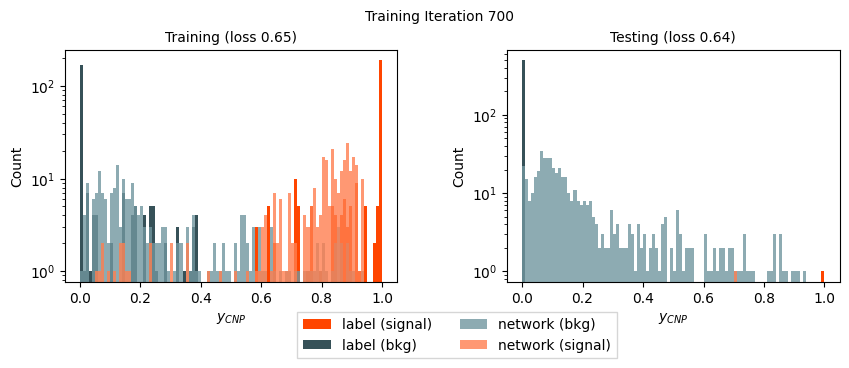

2025-04-04 14:02:41 Iteration: 1/750, train loss: 0.6622 (vs BCE 0.4801)
2025-04-04 14:02:41, Iteration: 750, test loss: 0.6317 (vs BCE 0.2656)


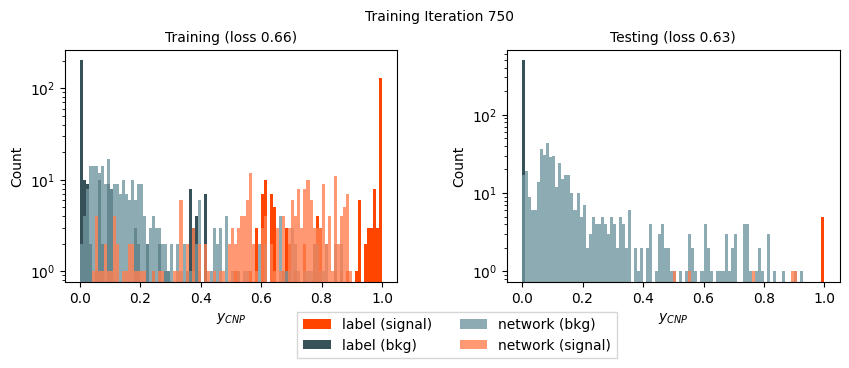

2025-04-04 14:02:46 Iteration: 1/800, train loss: 0.6587 (vs BCE 0.4315)
2025-04-04 14:02:46, Iteration: 800, test loss: 0.6901 (vs BCE 0.4114)


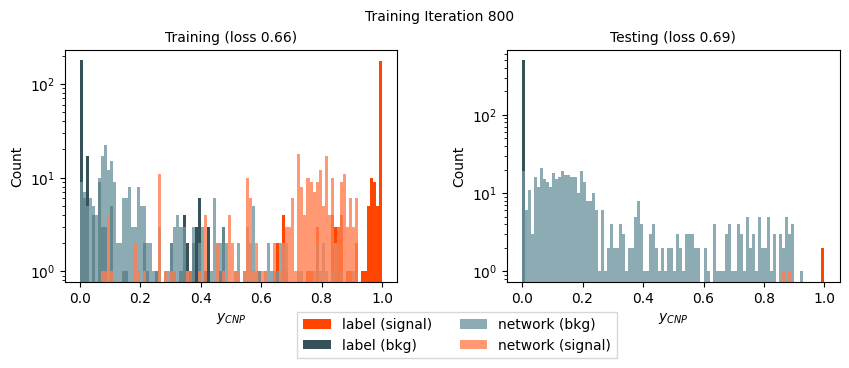

2025-04-04 14:02:51 Iteration: 1/850, train loss: 0.6577 (vs BCE 0.4674)
2025-04-04 14:02:51, Iteration: 850, test loss: 0.6628 (vs BCE 0.3528)


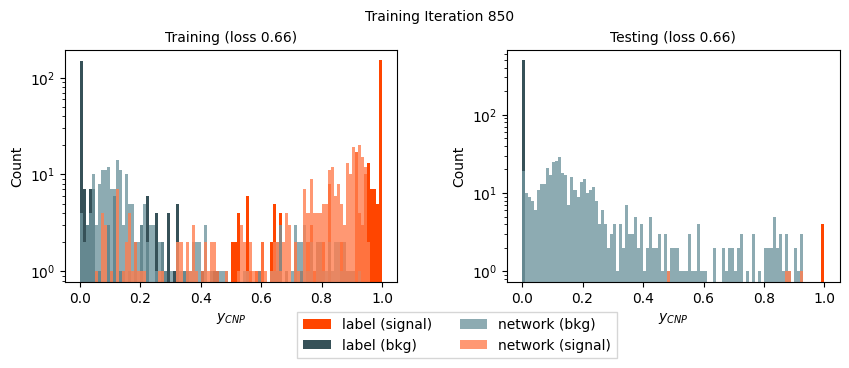

Finished full dataset pass. Starting new epoch! 


In [4]:

d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size*2
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes, decoder_sizes)
writer = SummaryWriter(log_dir=f'{path_out}/tensorboard_logs')

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# 

bce = nn.BCELoss()
iter_testing = 0

# create a PdfPages object
test_idx=0
it_batch = 0
for it_epoch in range(TRAINING_EPOCHS):
    
    USE_DATA_AUGMENTATION = config_file["cnp_settings"]["use_data_augmentation"]
    # load data:
    dataset_train = DataGeneration(mode = "training", config_file=config_file, path_to_files=config_file["path_settings"]["path_to_training_files"], use_data_augmentation=USE_DATA_AUGMENTATION, batch_size=BATCH_SIZE)
    dataset_train.set_loader()
    dataloader_train = dataset_train.dataloader

    dataset_test = DataGeneration(mode = "training", config_file=config_file, path_to_files=config_file["path_settings"]["path_to_training_files"], use_data_augmentation=False, batch_size=BATCH_SIZE)
    dataset_test.set_loader()
    dataloader_test = dataset_test.dataloader
    data_iter = iter(dataloader_test)

    #it_batch = 0
    
    for b, batch in enumerate(dataloader_train):
        batch_formated=dataset_train.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, _ = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        loss.backward()

        # Perform gradient descent to update parameters
        optimizer.step()
    
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1
        
        # Inside your batch loop, right after computing losses:
        writer.add_scalar('Loss/train_logprob', loss.item(), it_batch)
        if is_binary:
            writer.add_scalar('Loss/train_BCE', loss_bce.item(), it_batch)

        
        mu=mu[0].detach().numpy()
        
        if it_batch % 50 == 0:
            batch_testing = next(data_iter)
            batch_formated_test=dataset_train.format_batch_for_cnp(batch_testing,config_file["cnp_settings"]["context_is_subset"] )
          
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),it_epoch, it_batch,loss, loss_bce))
            
            writer.add_scalar('Loss/train_logprob', loss.item(), iter_testing)
            if is_binary:
                writer.add_scalar('Loss/train_BCE', loss_bce.item(), iter_testing)

            log_prob_testing, mu_testing, _ = model(batch_formated_test.query, batch_formated_test.target_y, is_binary)
            loss_testing = -log_prob_testing.mean()
            

            if is_binary:
                loss_bce_testing = bce(mu_testing,  batch_formated_test.target_y)
            else:
                loss_bce_testing = -1.

            writer.add_scalar('Loss/test_logprob', loss_testing.item(), test_idx)
            if is_binary:
                writer.add_scalar('Loss/test_BCE', loss_bce_testing.item(), test_idx)

            mu_testing = mu_testing[0].detach().numpy()
            print("{}, Iteration: {}, test loss: {:.4f} (vs BCE {:.4f})".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it_batch, loss_testing, loss_bce_testing))
            if y_size ==1:
                fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_testing, batch_formated_test.target_y[0].detach().numpy(), f'{loss_testing:.2f}', target_range, it_batch)
                writer.add_figure('Prediction/train_vs_test', fig, global_step=test_idx)
            else:
                for k in range(y_size):
                    fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_testing[:,k], batch_formated_test.target_y[0].detach().numpy()[:,k], f'{loss_testing:.2f}', target_range, it_batch)
                    writer.add_figure(f'Prediction/train_vs_test_k{k}', fig, global_step=test_idx)
            test_idx+=1
    
        it_batch+=1

writer.close()
torch.save(model.state_dict(), f'{path_out}/{f_out}_model.pth')
